# Analysis of the EU car trade network in recent years
by Hannah Schönborn and Máté Hekfusz

## Introduction

This Network Science project graphs and analyses the EU car trade network in the years of 2019 - 2022. This not only is the most recent complete data available (thus giving the most up-to-date picture of the trade network) but also includes the years of the Covid-19 crisis as we wanted to see how the pandemic affected the industry.

Data was gathered from [Eurostat](https://ec.europa.eu/eurostat/databrowser/view/DS-018995__custom_8842073/default/table?lang=en) and includes the trade value of car imports and exports to and from all EU countries. 

The major players in the EU are Germany, Belgium, Spain, France, Czech Republic, Slovakia and Italy - our analysis mainly focuses on them.

**Structure**

**1. Exploratory data analysis:**
- in-degree and out-degree value counts 
- in-degree and out-degree items and values
- edges and edge weights
- average degree of network
- adjacency matrix

**2. Network visualisation**

**3. Degree distribution (directed):**
- of network, 
- number of nodes/ bilateral realtionships per year and country

**4. Edge weight insights of the major players in the automobile industry**

**5. Covid-19 effects on trade values of the biggest exporters**
- Graphing
- Insights on the export values of major players in the automobile industry
- Changes of trade between the years
- Does the network approximate a scale-free model?

**6. Centrality measures:** 
- clustering coefficient
- betweeness and closeness centrality

**7. Conclusion**

The number of partners seems to be closely related to the trade value of exports and imports. The degree distributions for both number of nodes and trade value are ordered in the same way. Changes during the years in node number are also reflected in the trade value.

- Potential differences in ranking of countries between degree and sum of trade value, prove that degree is a good measure
- Does the network approximate a scale-free model?

## Load libraries and data

In [34]:
import collections
import warnings
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from matplotlib.ticker import FuncFormatter
from pyvis import network as net
from scipy.stats import norm

%matplotlib inline

In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
countries = pd.read_csv("country-codes.csv") # Load country codes
countries.loc[countries["Code"] == "RS", "Code"] = "XS" # Correct Serbia's country code

countries = dict(zip(countries['Name'], countries['Code'])) # Convert to dictionary
countries

{'Afghanistan': 'AF',
 'Åland Islands': 'AX',
 'Albania': 'AL',
 'Algeria': 'DZ',
 'American Samoa': 'AS',
 'Andorra': 'AD',
 'Angola': 'AO',
 'Anguilla': 'AI',
 'Antarctica': 'AQ',
 'Antigua and Barbuda': 'AG',
 'Argentina': 'AR',
 'Armenia': 'AM',
 'Aruba': 'AW',
 'Australia': 'AU',
 'Austria': 'AT',
 'Azerbaijan': 'AZ',
 'Bahamas': 'BS',
 'Bahrain': 'BH',
 'Bangladesh': 'BD',
 'Barbados': 'BB',
 'Belarus': 'BY',
 'Belgium': 'BE',
 'Belize': 'BZ',
 'Benin': 'BJ',
 'Bermuda': 'BM',
 'Bhutan': 'BT',
 'Bolivia, Plurinational State of': 'BO',
 'Bonaire, Sint Eustatius and Saba': 'BQ',
 'Bosnia and Herzegovina': 'BA',
 'Botswana': 'BW',
 'Bouvet Island': 'BV',
 'Brazil': 'BR',
 'British Indian Ocean Territory': 'IO',
 'Brunei Darussalam': 'BN',
 'Bulgaria': 'BG',
 'Burkina Faso': 'BF',
 'Burundi': 'BI',
 'Cambodia': 'KH',
 'Cameroon': 'CM',
 'Canada': 'CA',
 'Cape Verde': 'CV',
 'Cayman Islands': 'KY',
 'Central African Republic': 'CF',
 'Chad': 'TD',
 'Chile': 'CL',
 'China': 'CN',
 'Chr

In [4]:
data = pd.read_csv("eu-car-trade.csv") # Load data
data["reporter"] = data["reporter"].astype(str)
data["partner"] = data["partner"].astype(str)
data.dtypes

DATAFLOW        object
LAST UPDATE     object
freq            object
reporter        object
partner         object
product          int64
flow             int64
indicators      object
TIME_PERIOD      int64
OBS_VALUE        int64
OBS_FLAG       float64
dtype: object

## 1. Exploratory Data Analysis

We filter our data to only include car trade connections worth over 200 million Euros: this transforms the data from a complete network (as every country trades with every other country) to a network that's sparser but easier to understand and visualise. For the most part, we also only consider the exports data as between EU countries, exports and imports mirror each other: country A's export into country B is equal to country B's import from country A.

In [5]:
data_2 = data[data['reporter'] != 'GB'] # We have decided to remove the UK from the reporting (aka EU) countries list as it only featured as such in the 2019 data
filtered_data = data_2[(data_2["OBS_VALUE"] > 200_000_000) & (data_2["flow"] == 2)] # flow: (2) exports, (1) imports
filtered_data

DATAFLOW        LAST UPDATE freq reporter partner  product  \
63     ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       AT      BE      781   
64     ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       AT      BE      781   
65     ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       AT      BE      781   
66     ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       AT      BE      781   
145    ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       AT      CN      781   
...                     ...                ...  ...      ...     ...      ...   
16900  ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       SK      SE      781   
16966  ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       SK      US      781   
16967  ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       SK      US      781   
16968  ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       SK      US      781   
16969  ESTAT:DS-018995(1.0)  15/11/23 11:00:00    A       SK      US      781   

       flow      indicators  TIME_PERIOD   OBS_VALUE  OBS_FLAG  
63        2  VALUE_IN_EUROS         2019   686261550       NaN  
64        2  VALUE_IN_EUROS         2020   471402100       NaN  
65        2  VALUE_IN_EUROS         2021   438542543       NaN  
66        2  VALUE_IN_EUROS         2022   433252066       NaN  
145       2  VALUE_IN_EUROS         2019   228281819       NaN  
...     ...             ...          ...         ...       ...  
16900     2  VALUE_IN_EUROS         2022   444056747       NaN  
16966     2  VALUE_IN_EUROS         2019  1669896864       NaN  
16967     2  VALUE_IN_EUROS         2020  2095732395       NaN  
16968     2  VALUE_IN_EUROS         2021  1829988462       NaN  
16969     2  VALUE_IN_EUROS         2022  2157210083       NaN  

[888 rows x 11 columns]

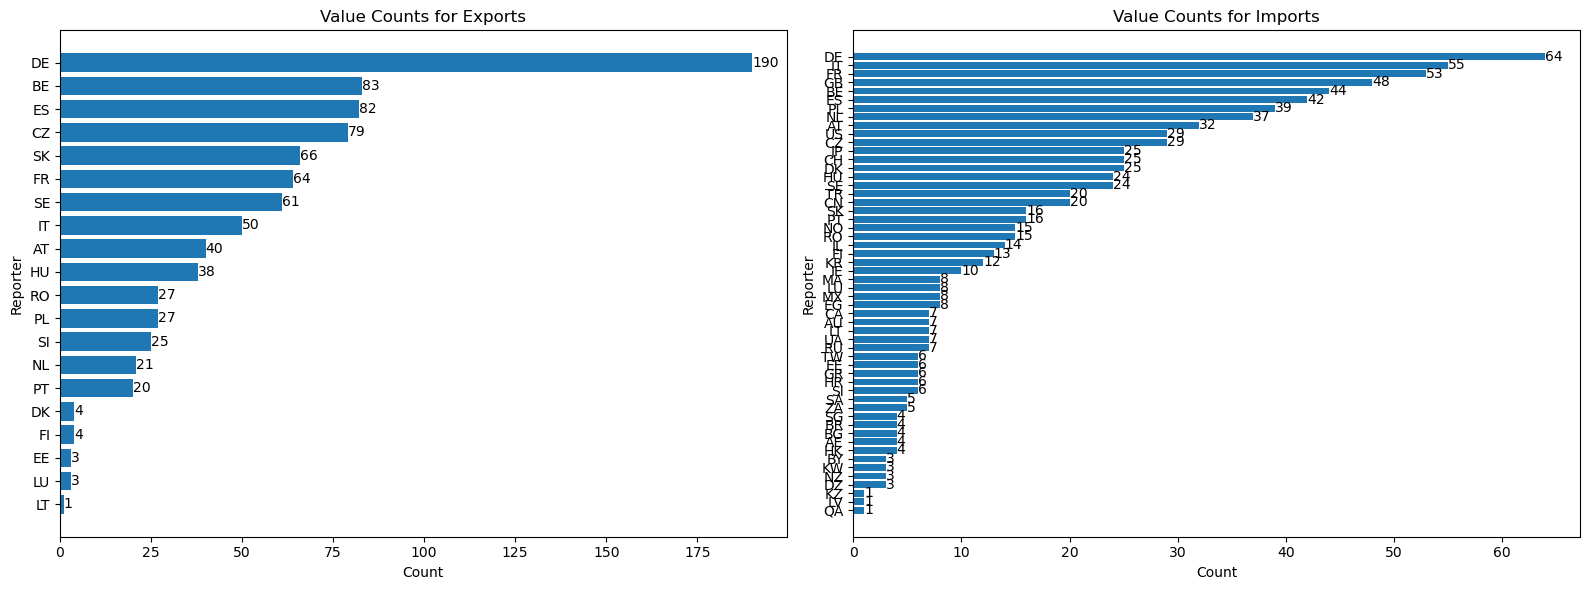

In [6]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the horizontal bar chart for exports
values_out = filtered_data["reporter"].value_counts()
axs[0].barh(values_out.index, values_out)
axs[0].invert_yaxis()

# Add annotations to the bars in the first chart
for index, value in enumerate(values_out):
    axs[0].text(value, index, str(value), ha='left', va='center', fontsize=10)

axs[0].set_xlabel('Count')
axs[0].set_ylabel('Reporter')
axs[0].set_title('Value Counts for Exports')

# Plot the horizontal bar chart for imports
values_in = filtered_data["partner"].value_counts()
axs[1].barh(values_in.index, values_in)
axs[1].invert_yaxis()

# Add annotations to the bars in the second chart
for index, value in enumerate(values_in):
    axs[1].text(value, index, str(value), ha='left', va='center', fontsize=10)

axs[1].set_xlabel('Count')
axs[1].set_ylabel('Reporter')
axs[1].set_title('Value Counts for Imports')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

The above graphs show how many times each country appears in the filtered dataset for all four years: in other words, how many trade relationships above 200 million Euros they have. We can already see a trand that will appear many times in our analysis: that Germany dominates the European car export market. Imports are more balanced, showing that the rich Western European countries from France to Belgium import the most.

We use the networkx package to turn our data into a network.

In [17]:
# Create directed network from data
G_dir = nx.from_pandas_edgelist(filtered_data, "reporter", "partner", edge_attr="OBS_VALUE", create_using=nx.DiGraph)

# Create networks for the individual years as well, helpful for some later calculations
year_networks = {}
unique_years = sorted(filtered_data['TIME_PERIOD'].unique())
for year in unique_years:
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]
    year_networks[year] = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', 'OBS_VALUE', create_using=nx.DiGraph)

# Extract the k-core subgraph of the graph with k=2 edges
G_dir_core = nx.k_core(G_dir, 2) 

print("Complete - Number of nodes:", G_dir.number_of_nodes(), "\nComplete - Number of edges:", G_dir.number_of_edges(),"\n")
print("Core - Number of nodes:", G_dir_core.number_of_nodes(), "\nCore - Number of edges:", G_dir_core.number_of_edges())

Complete - Number of nodes: 54 
Complete - Number of edges: 272 

Core - Number of nodes: 43 
Core - Number of edges: 261


**Properties of directed networks**

In [18]:
# Calculate degree centrality

# Directed edge count

degree_map = {} # create a map

degree_map = collections.defaultdict(int)
for node_a,node_b in G_dir.edges(): #loop through edges
  degree_map[node_a] += 1
  degree_map[node_b] += 1

# Directed edge count for each country
print("Edge items in order:", sorted(list(degree_map.items()), key=lambda tup: tup[1], reverse = True))

Edge items in order: [('DE', 68), ('BE', 38), ('ES', 38), ('FR', 36), ('CZ', 32), ('IT', 28), ('SK', 27), ('SE', 23), ('HU', 22), ('AT', 21), ('PL', 21), ('NL', 17), ('RO', 15), ('GB', 14), ('SI', 11), ('US', 9), ('PT', 9), ('DK', 8), ('JP', 7), ('CH', 7), ('CN', 6), ('NO', 6), ('TR', 6), ('KR', 5), ('FI', 5), ('IL', 5), ('LU', 4), ('AU', 4), ('EG', 4), ('LT', 4), ('CA', 3), ('IE', 3), ('TW', 3), ('MX', 3), ('BY', 3), ('EE', 3), ('GR', 3), ('SA', 2), ('HR', 2), ('MA', 2), ('RU', 2), ('UA', 2), ('ZA', 2), ('AE', 1), ('BG', 1), ('BR', 1), ('HK', 1), ('KW', 1), ('KZ', 1), ('LV', 1), ('NZ', 1), ('QA', 1), ('SG', 1), ('DZ', 1)]


In [19]:
# Dictionary to store edge weights

edge_weights = [G_dir.edges[edge]["OBS_VALUE"] for edge in G_dir.edges]
edge_weights_out = {}
edge_weights_in = {}
sum_edge_weights_out = {node: 0 for node in G_dir.nodes()} 
sum_edge_weights_in = {node: 0 for node in G_dir.nodes()} 

# Remove self-loops
G_dir.remove_edges_from(nx.selfloop_edges(G_dir))

# Check the number of graph edges matches with the number of edge weights
print("Number of edges in graph:", len(G_dir.edges))
print("Length of edge_weights:", len(edge_weights))
print()

# Directed edge count

in_degree_map = {node: 0 for node in G_dir.nodes()}
out_degree_map = {node: 0 for node in G_dir.nodes()}

for source, target, weight in G_dir.edges(data='OBS_VALUE', default=0):  # Loop through edges with weights
    out_degree_map[source] += 1  # Out-degree from the reporter (source)
    in_degree_map[target] += 1   # In-degree to the partner (target)
    sum_edge_weights_out[source] += weight  # Sum edge weights per country (source)
    sum_edge_weights_in[target] += weight  # Sum edge weights per country (target)
    edge_weights_out[(source, target)] = weight  # Edge weight in the dictionary from the reporter (source)
    edge_weights_in[(target, source)] = weight   # Edge weight to the partner (target)

# print(in_degree_map)
# print(out_degree_map)

print("Indegree map items:", list(in_degree_map.items())[:5])
print("In-degree edge weights (country):", sum_edge_weights_in)
print("In-degree edge weights (single):", edge_weights_in)

print()

print("Outdegree map items:", list(out_degree_map.items())[:5])
print("Out-degree edge weights (country):", sum_edge_weights_out)
print("Out-degree edge weights (single):", edge_weights_out)

Number of edges in graph: 272
Length of edge_weights: 272

Indegree map items: [('AT', 9), ('BE', 12), ('CN', 6), ('CZ', 8), ('DE', 16)]
In-degree edge weights (country): {'AT': 7647415625, 'BE': 15740622857, 'CN': 24299112268, 'CZ': 4160911624, 'DE': 48388064580, 'GB': 26713348055, 'HU': 3415066827, 'IT': 19584142794, 'JP': 5618503224, 'KR': 8172332965, 'RO': 2326329980, 'SK': 2595123738, 'US': 36378286539, 'CA': 2913090212, 'CH': 6770033668, 'DK': 4771500815, 'ES': 11246713743, 'FI': 2123419737, 'FR': 28267376475, 'IE': 1550590023, 'IL': 1863825366, 'LU': 1723860660, 'NL': 12509737626, 'NO': 5633867323, 'PL': 9770946982, 'PT': 3019562892, 'SE': 7484900193, 'TR': 5115451887, 'TW': 2129886585, 'AU': 2585830889, 'EG': 1273594275, 'MX': 1113585115, 'SA': 886933814, 'AE': 1186938168, 'BG': 426481537, 'BR': 470310976, 'BY': 1424650412, 'EE': 704712248, 'GR': 832009824, 'HK': 435630561, 'HR': 643956351, 'KW': 257487788, 'KZ': 353630449, 'LT': 899911634, 'LV': 282934229, 'MA': 689749848, 'NZ

In [20]:
# Check total number of links: sum(in_degree) = sum (out_degree)
total_degree_map = {node: in_degree_map[node] + out_degree_map[node] for node in G_dir.nodes()}

# Initialize total in-degree and out-degree sums
total_in_degree_sum = 0
total_out_degree_sum = 0

# Sum of in-degrees and out-degrees for each node
for node in G_dir.nodes():
    total_in_degree_sum += in_degree_map[node]
    total_out_degree_sum += out_degree_map[node]

print("Total No. of Links")
print("= Sum of In-Degrees:", total_in_degree_sum)
print("= Sum of Out-Degrees:", total_out_degree_sum)

Total No. of Links
= Sum of In-Degrees: 272
= Sum of Out-Degrees: 272


The sum of in and out degrees in any directed network should be the same, and we see that it's true for ours too. Note that this is for the full network which includes data from all four years - or in other words, up to eight edges between the same two nodes.

In [29]:
# Average degree of network

# Calculate the total sum of degrees
total_degree_sum = sum(degree_map.values())
print("Sum of degrees:", total_degree_sum)

# Calculate the total number of nodes
total_nodes = len(G_dir.nodes())
print("No. of nodes:",total_nodes)

# Calculate the average degree
average_degree = total_degree_sum / total_nodes

print("Average degree (sum of degrees / no. of nodes) for the whole network:", average_degree)
print("Average degree per year:")
for year in year_networks:
    degrees = dict(year_networks[year].degree())
    avg_degree = sum(degrees.values()) / len(degrees)
    print("{}: {}".format(year, avg_degree))

Sum of degrees: 544
No. of nodes: 54
Average degree (sum of degrees / no. of nodes) for the whole network: 10.074074074074074
Average degree per year:
2019: 8.979591836734693
2020: 8.458333333333334
2021: 8.72
2022: 9.148148148148149


The average degree breakdown by year shows that the average degree of the network decreased during Covid but not by much, and that it also bounced back by 2022. This suggests that on the highest level of European car trade, the pandemic didn't affect things severely.

**Adjacency matrix**

We have also built the adjacency matrix for our network.

In [12]:
# Adjacency matrix

# Get the country names
country_names = list(G_dir.nodes())

# Adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G_dir, nodelist=country_names)

# Convert the adjacency matrix to a dense matrix
dense_matrix = adjacency_matrix.todense()

# Print the dense matrix with country names
# print("Adjacency Matrix:")
# print(pd.DataFrame(dense_matrix, index=country_names, columns=country_names))

In [13]:
# Initialize an empty DataFrame to store the adjacency matrix with edge values
adjacency_matrix_df = pd.DataFrame(index=country_names, columns=country_names)

# Populate the DataFrame with edge values
for edge in G_dir.edges(data=True):
    source, target, value = edge
    adjacency_matrix_df.at[source, target] = value['OBS_VALUE']

# Fill NaN values with 0 (for non-existing edges)
adjacency_matrix_df = adjacency_matrix_df.fillna(0)

# Print the adjacency matrix DataFrame with edge values
print("Adjacency matrix with edge weights:")
adjacency_matrix_df.head()


Adjacency matrix with edge weights:


AT          BE           CN          CZ          DE           GB  \
AT           0   433252066    650758147   454697203  1299332737    503054626   
BE   494008971           0    232218847   270216610  6860632399   1691757126   
CN           0           0            0           0           0            0   
CZ   733466230  1077892300            0           0  5499882423   2072898479   
DE  4264805586  5684178839  19477511755  1772163169           0  11616600136   

            HU          IT          JP          KR  ...         LV         MA  \
AT   354137258   203708239   289386471   552028079  ...          0          0   
BE   269990612   936039458   270152108           0  ...          0          0   
CN           0           0           0           0  ...          0          0   
CZ   515382708  1364092565           0           0  ...          0          0   
DE  1111097184  7927091655  3513800183  6966922452  ...  282934229  366493200   

           NZ         QA         RU         SG         SI         UA  \
AT          0          0          0          0          0          0   
BE          0          0          0          0          0          0   
CN          0          0          0          0          0          0   
CZ          0          0          0          0          0          0   
DE  224786475  215097837  548398402  266194581  493948259  328181136   

           ZA  DZ  
AT          0   0  
BE          0   0  
CN          0   0  
CZ          0   0  
DE  592845706   0  

[5 rows x 54 columns]

## 2. Visualising the trade network

Using the Pyvis network visualisation library, we create full, interactive graphs of the car trade networks for each year. The below code generates these visualisations, which are then saved as html files. To save space, we only display the latest, 2022 network graph in this report, while the others can be viewed by clicking on the links below:
- [2019](car-trade-network-2019.html)
- [2020](car-trade-network-2020.html)
- [2021](car-trade-network-2021.html)

In [35]:
countries_by_code = {v: k for k, v in countries.items()} # Invert country code dictionary to have the codes as the keys

colors = {}
euCountries = filtered_data["reporter"].unique()

random.seed(2) # Seed to guarantee the same colours every time
for i in range(len(euCountries)): # Generate random colours for each EU country node, so the edges can be coloured based on which node they originate from
    colors[euCountries[i]] = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 

In [37]:
def formatValue(num): # Format monetary values into human-readable format with millions and billions
    if num > 1000000000:
        if not num % 1000000000:
            return f'€{num // 1000000000}B'
        return f'€{round(num / 1000000000, 1)}B'        
    elif num > 1000000:
        if not num % 1000000:
            return f'€{num // 1000000}M'
        return f'€{round(num / 1000000, 1)}M'
    return f'€{num // 1000}K'

In [ ]:
# Create interactive network visualisations for all four years
for year in unique_years:

    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]
   
    visnet = net.Network(notebook = True, cdn_resources = "in_line", directed = True, select_menu = True, filter_menu = True) # Create network (note that the parameters used are for displaying it in-line in a Jupyter notebook; if you use something else, these params might be different)
    
    for idx, row in filtered_data_year.iterrows():
      
        reporterImage = "https://flagicons.lipis.dev/flags/4x3/" + row['reporter'].lower() + ".svg" # Country icon URLs
        partnerImage = "https://flagicons.lipis.dev/flags/4x3/" + row['partner'].lower() + ".svg"
        
        reporterDegree = filtered_data_year[filtered_data_year["reporter"] == row["reporter"]]["reporter"].count() # Country degrees, which determine the size of the node
        partnerDegree = filtered_data_year[filtered_data_year["partner"] == row["partner"]]["partner"].count()
    
        visnet.add_node(n_id = row['reporter'], label = countries_by_code[row['reporter']], title = row['reporter'], image = reporterImage, shape = 'circularImage', size = int(reporterDegree) * 2)
        visnet.add_node(n_id = row['partner'], label = countries_by_code[row['partner']], title = row['partner'], image = partnerImage, shape = 'circularImage', size = int(partnerDegree) * 2)
        visnet.add_edge(source = row['reporter'], to = row['partner'], value = int(row['OBS_VALUE']) / 200000000, title = formatValue(int(row['OBS_VALUE'])), color = colors[row['reporter']])
    
    visnet.repulsion(spring_length = 500, node_distance = 300) # Spread the nodes out so that the graph is easier to process
    visnet.show_buttons(filter_ = ["physics"]) # Show physics control panel

    fileName = "car-trade-network-" + str(year) + ".html"
    visnet.save_graph(fileName) # Save graph as html

In [39]:
# Show the latest network
visnet.show("car-trade-network-2022.html")

## 3. Degree distributions

### Complete Network 

Shows the degree distributions in the complete network comprising of all four years.

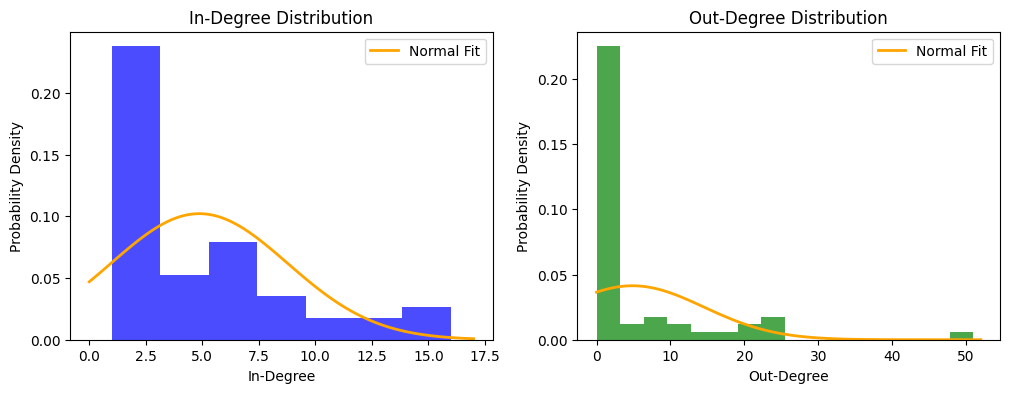

In [1056]:
# Extract the in-degree and out-degree sequences
in_degree_sequence = list(in_degree_map.values())
out_degree_sequence = list(out_degree_map.values())

# Plot histograms for in-degree and out-degree distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot histogram for in-degree with distribution curve
axs[0].hist(in_degree_sequence, bins='auto', density=True, alpha=0.7, color='blue')
axs[0].set_title('In-Degree Distribution')
axs[0].set_xlabel('In-Degree')
axs[0].set_ylabel('Probability Density')

# Fit normal distribution to the in-degree data
mu, std = norm.fit(in_degree_sequence)
xmin, xmax = plt.xlim()
x = np.linspace(0, max(in_degree_sequence) + 1, 100)
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
legend1 = axs[0].legend()

# Plot histogram for out-degree with distribution curve
axs[1].hist(out_degree_sequence, bins='auto', density=True, alpha=0.7, color='green')
axs[1].set_title('Out-Degree Distribution')
axs[1].set_xlabel('Out-Degree')
axs[1].set_ylabel('Probability Density')

# Fit normal distribution to the out-degree data
mu, std = norm.fit(out_degree_sequence)
xmin, xmax = plt.xlim()
x = np.linspace(0, max(out_degree_sequence) + 1, 100)
p = norm.pdf(x, mu, std)
axs[1].plot(x, p, 'k', linewidth=2, label='Normal Fit', color='orange')
legend2 = axs[1].legend()

### Degree Distribution Separated by Year

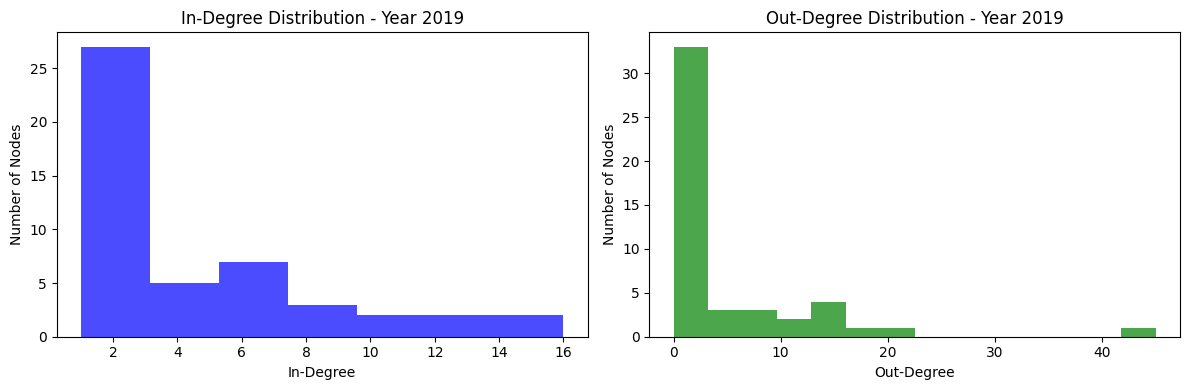

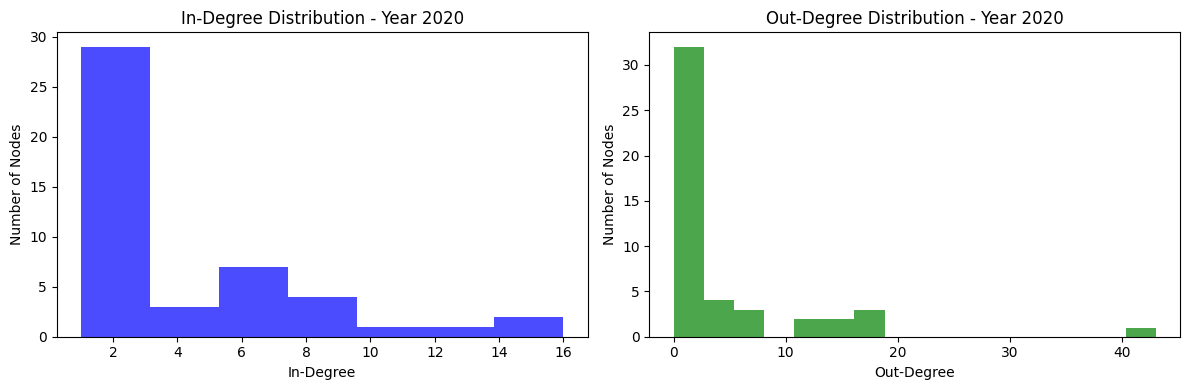

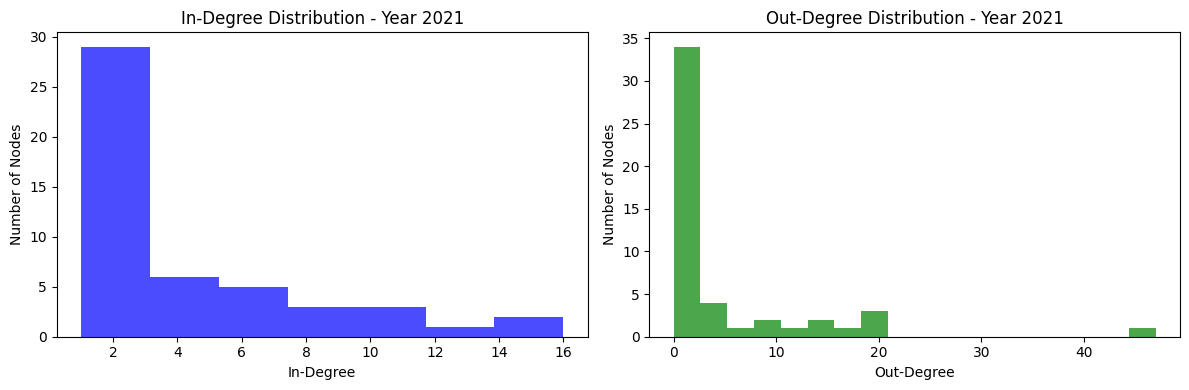

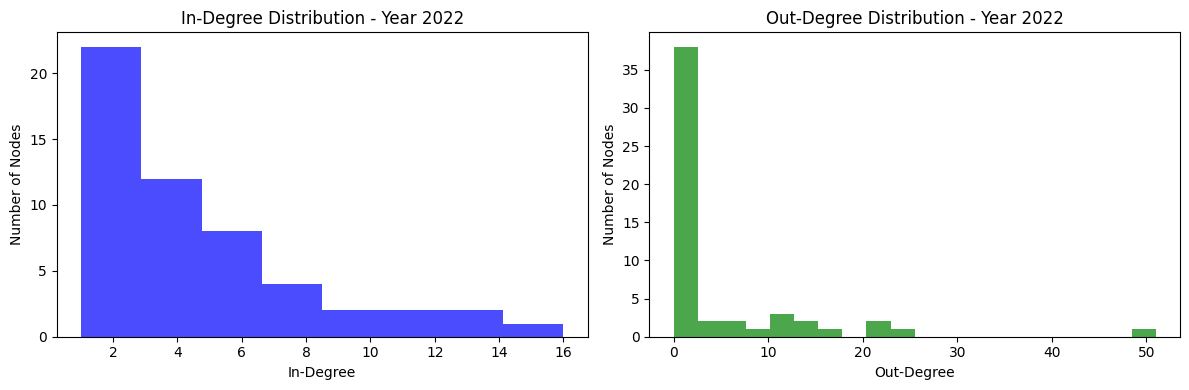

In [1057]:
# List of unique years in the dataset
unique_years= sorted(filtered_data['TIME_PERIOD'].unique())

for year in unique_years:
    # Filter data for the current year
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', 'OBS_VALUE', create_using=nx.DiGraph)

    # Reset indegree and outdegree maps for the current year
    in_degree_map_year = {node: 0 for node in graph_year.nodes()}
    out_degree_map_year = {node: 0 for node in graph_year.nodes()}

    # Calculate indegree and outdegree values
    for source, target in graph_year.edges(): # loop through edges
        if source in out_degree_map_year:
            out_degree_map_year[source] += 1  # out-degree from the reporter (source)
        else:
            out_degree_map_year[source] = 1   # initialize out-degree for the new source node

        if target in in_degree_map_year:
            in_degree_map_year[target] += 1   # in-degree to the partner (target)
        else:
            in_degree_map_year[target] = 1    # initialize in-degree for the new target node

    # Apply in-degree and out-degree sequence for the current year
    in_degree_sequence_year = list(in_degree_map_year.values())
    out_degree_sequence_year = list(out_degree_map_year.values())

    # Plot histograms for in-degree and out-degree distributions
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    axs[0].hist(in_degree_sequence_year, bins='auto', density=False, alpha=0.7, color='blue') 
    axs[0].set_title(f'In-Degree Distribution - Year {year}')
    axs[0].set_xlabel('In-Degree')
    axs[0].set_ylabel('Number of Nodes') # density=True -> 'Probability Density'

    axs[1].hist(out_degree_sequence_year, bins='auto', density=False, alpha=0.7, color='green')
    axs[1].set_title(f'Out-Degree Distribution - Year {year}')
    axs[1].set_xlabel('Out-Degree')
    axs[1].set_ylabel('Number of Nodes')
    
    plt.tight_layout()
    plt.show()

# print(exports_bar_df)


**The network has a right-skewed distrubution in all years.** This right-tailed distribution is characterized by a longer right tail compared to the left side. 

**Right-Skewed In-Degree Distribution:**

Nodes with higher in-degrees are less common, but there are a few nodes with significantly higher in-degrees than the majority.
In the context of car imports, this suggests that most countries have relatively low numbers of other countries exporting cars to them over the value of 200 million EUR. However, there are a few countries that receive cars from a significantly larger number of partners over that amount.

**Right-Skewed Out-Degree Distribution:**

Nodes with higher out-degrees are less common, but there are a few nodes with significantly higher out-degrees than the majority.
In the context of car exports, this suggests that most countries export cars to a relatively low number of other countries over the value of 200 million EUR. However, there are a few countries that export cars to a significantly larger number of partners over that amount.

We can interpret these properties in multiple ways:
<br>
**Hubs or Dominant Players:** The few nodes with high in-degrees (importers) or out-degrees (exporters) can be considered as "hubs" or dominant players in the network. These countries may have strong economic ties or a significant market share in the car trade.
<br>
**Trade Imbalances:** In the case of a skewed distribution, there may be a significant imbalance in the car trade. Some countries may be major importers, receiving cars from various sources, while others may be major exporters, sending cars to numerous destinations.
<br>
**Specialization:** Countries with high out-degrees might be specializing in car manufacturing and exporting, while those with high in-degrees are likely more of a customer market which imports cars rather than manufacture them. The skewed distribution could reflect specialization in certain industries or economic activities, as is often the case in today's globalised world.
<br>
**Network Structure:** The right-skewed distribution suggests that the network has a hierarchical or scale-free structure, where a small number of nodes (countries) play a central role, and the majority have lower connectivity.

**Further insights on the degree distributions per year**

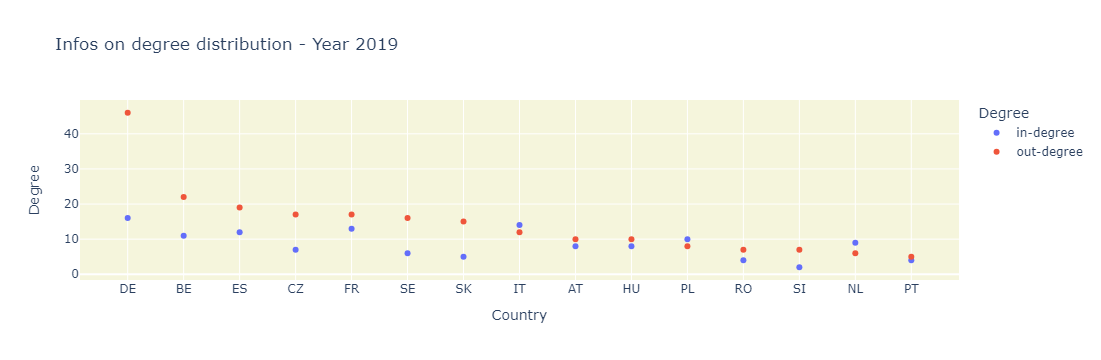

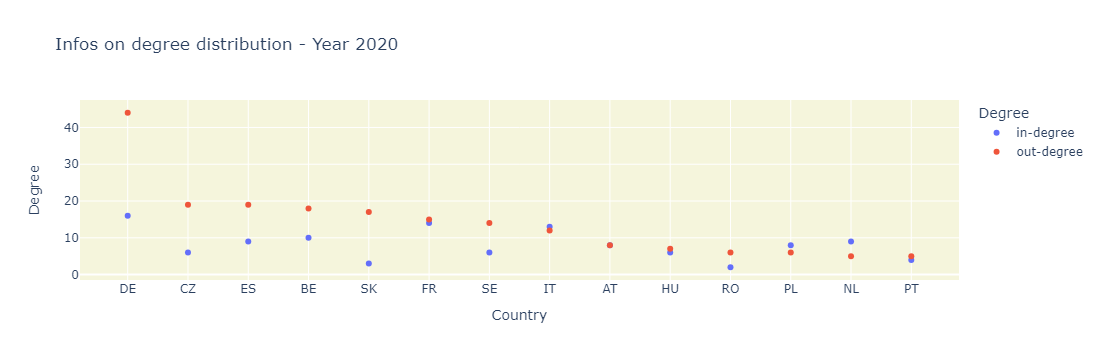

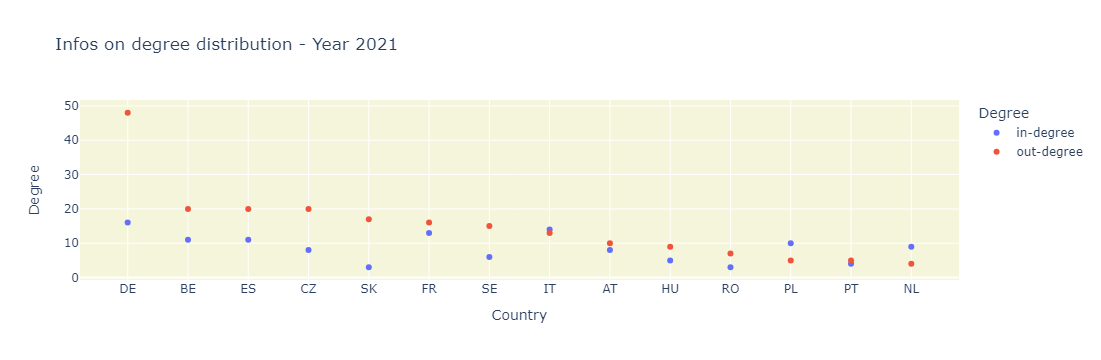

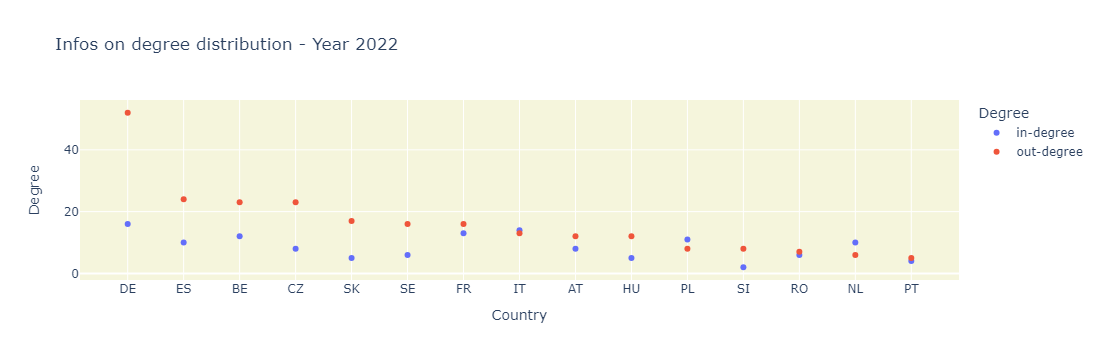

In [30]:
for year in unique_years:
    # Filter data for the current year
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', edge_attr="OBS_VALUE", create_using=nx.DiGraph)

    # Reset indegree and outdegree maps for the current year
    in_degree_map_year = {node: 0 for node in graph_year.nodes()}
    out_degree_map_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_out_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_in_year = {node: 0 for node in graph_year.nodes()}

    # Calculate indegree and outdegree values
    for source, target, weight in graph_year.edges(data="OBS_VALUE", default=0):
        out_degree_map_year[source] += 1            # out-degree from the reporter (source)
        in_degree_map_year[target] += 1             # in-degree to the partner (target)
        sum_edge_weights_out_year[source] += weight # out-degree weights
        sum_edge_weights_in_year[target] += weight  # in-degree weights

    # Filter out nodes with only 1 in-degree or 0 out-degree
    filtered_nodes = [node for node in graph_year.nodes() if in_degree_map_year[node] > 1 and out_degree_map_year[node] > 1]

    # Ensure that in-degree and out-degree arrays have the same length
    common_nodes = list(set(filtered_nodes) & set(in_degree_map_year) & set(out_degree_map_year))
    out_degree_nodes_year = [out_degree_map_year[node] for node in common_nodes]
    in_degree_nodes_year = [in_degree_map_year[node] for node in common_nodes]
    out_degree_weights_year = [sum_edge_weights_out_year[node] for node in common_nodes]
    in_degree_weights_year = [sum_edge_weights_in_year[node] for node in common_nodes]

    # Create a dataframe for the scatter plot
    scatter_data = pd.DataFrame({
        'country': [countries.get(code, code) for code in common_nodes],
        'out-degree': out_degree_nodes_year,
        'in-degree': in_degree_nodes_year,
        'Exports': out_degree_weights_year,
        'Imports': in_degree_weights_year
    })

    # Sort scatter_data by In-Degree and Out-Degree values
    scatter_data = scatter_data.sort_values(by=['out-degree'], ascending=False)

    # Create scatter plot using plotly express without category_orders
    fig = px.scatter(scatter_data, x='country', y=['in-degree', 'out-degree'],
                     labels={'variable': 'Degree type', 'country': 'Country', 'value': 'Degree'},
                     title=f'Infos on degree distribution - Year {year}', hover_name='country')

    # Set the legend title to "Degrees"
    fig.update_layout(legend_title_text='Degree')

    # Set background color of the grid
    fig.update_layout(plot_bgcolor='beige')

    # Show the figure with title and legend
    fig.show()

The above graphs show the differences in the in-degree (imports) and out-degree (exports) of EU countries. We can see that **Germany** has by far the largest difference, which we also observed in previous graphs: this means that the country exports way more cars than it imports, which makes sense given that it's Europe's largest car manufacturing hub. Other manufacturing countries like **Slovakia** and **Czechia** also export a lot more.

Another interesting insight is that **Hungary** has been exporting more and more over the last couple of years, while import levels have stayed virtually the same. This can be explained by the government's massive efforts to bring automotive companies and assembly factories into the country.

## 4. Edge weight insights

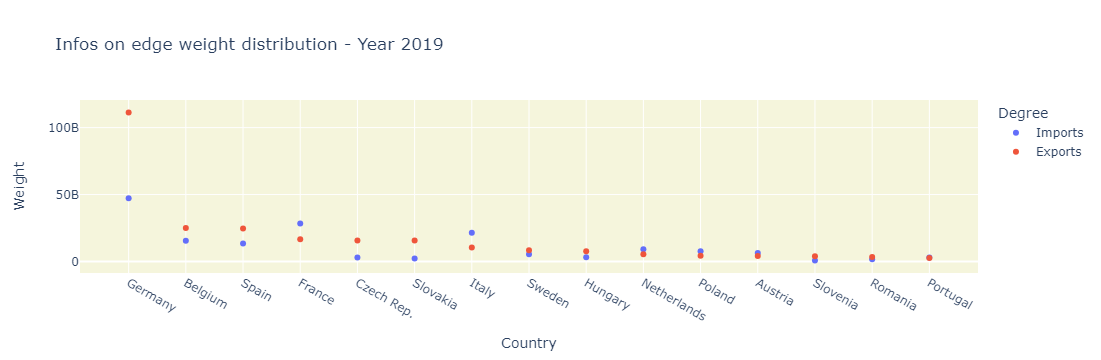

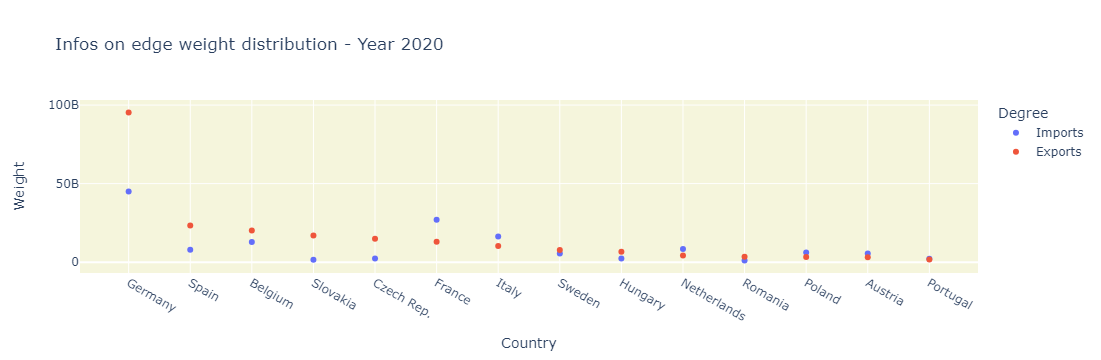

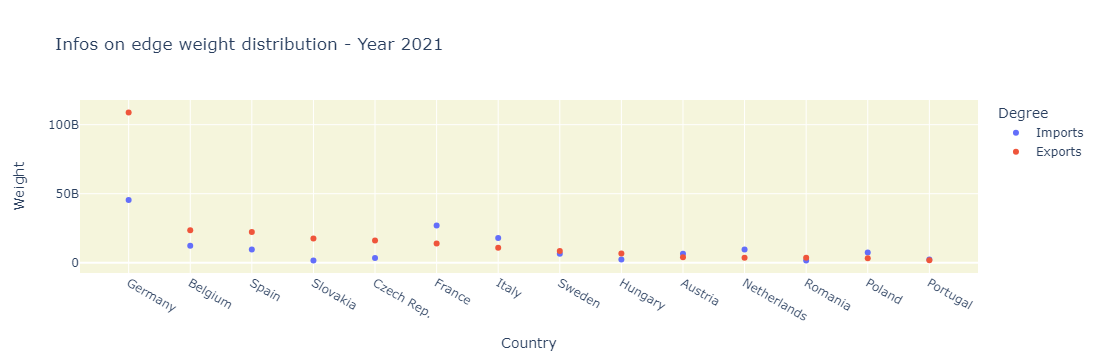

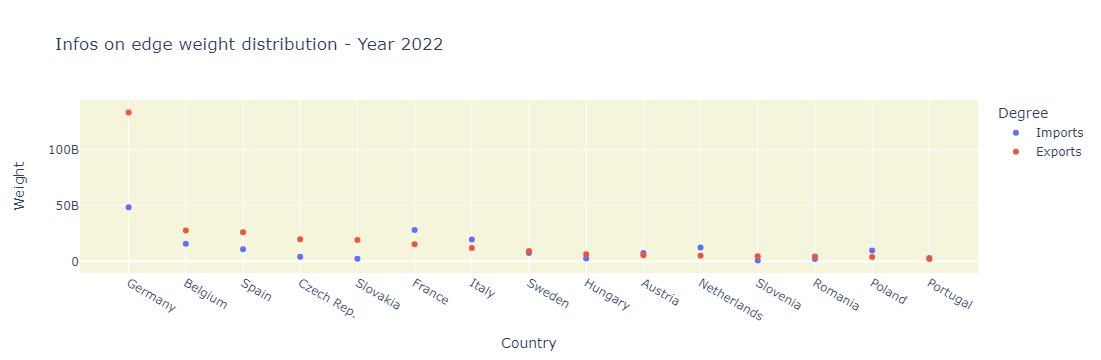

In [1059]:
for year in unique_years:
    # Filter data for the current year
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', edge_attr="OBS_VALUE", create_using=nx.DiGraph)

    # Reset indegree and outdegree maps for the current year
    in_degree_map_year = {node: 0 for node in graph_year.nodes()}
    out_degree_map_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_out_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_in_year = {node: 0 for node in graph_year.nodes()}

    # Calculate indegree and outdegree values
    for source, target, weight in graph_year.edges(data="OBS_VALUE", default=0):
        out_degree_map_year[source] += 1            # out-degree from the reporter (source)
        in_degree_map_year[target] += 1             # in-degree to the partner (target)
        sum_edge_weights_out_year[source] += weight # out-degree weights
        sum_edge_weights_in_year[target] += weight  # in-degree weights

    # Filter out nodes with only 1 in-degree or 0 out-degree
    filtered_nodes = [node for node in graph_year.nodes() if in_degree_map_year[node] > 1 and out_degree_map_year[node] > 1]

    # Ensure that in-degree and out-degree arrays have the same length
    common_nodes = list(set(filtered_nodes) & set(in_degree_map_year) & set(out_degree_map_year))
    out_degree_nodes_year = [out_degree_map_year[node] for node in common_nodes]
    in_degree_nodes_year = [in_degree_map_year[node] for node in common_nodes]
    out_degree_weights_year = [sum_edge_weights_out_year[node] for node in common_nodes]
    in_degree_weights_year = [sum_edge_weights_in_year[node] for node in common_nodes]

    # Create a dataframe for the scatter plot
    scatter_data = pd.DataFrame({
        'country': [countries.get(code, code) for code in common_nodes],
        'out-degree': out_degree_nodes_year,
        'in-degree': in_degree_nodes_year,
        'Exports': out_degree_weights_year,
        'Imports': in_degree_weights_year
    })

    # Sort scatter_data by In-Degree and Out-Degree values
    scatter_data = scatter_data.sort_values(by=['Exports'], ascending=False)

    # Create scatter plot using plotly express without category_orders
    fig = px.scatter(scatter_data, x='country', y=['Imports', 'Exports'],
                     labels={'variable': 'Degree type', 'country': 'Country', 'value': 'Weight'},
                     title=f'Infos on edge weight distribution - Year {year}', hover_name='country')

    # Set the legend title to "Degrees"
    fig.update_layout(legend_title_text='Degree')

    # Set background color of the grid
    fig.update_layout(plot_bgcolor='beige')

    # Show the figure with title and legend
    fig.show()

The graphs by edge weight show many of the patterns as the previous ones by degree. This suggests that the degree is a good proxy measure while being very simple to calculate. It should be noted, however, that our previous observation about the increase in Hungary's car exports is somewhat refuted by these value graphs, which show that despite the increase in degree, the total value of exports over 200 million has actually decreased over the years.

## 5. Covid-19 effect on trade values of the biggest exporters

In [1060]:
# Assuming you have a list of unique years named 'unique_years'
all_bar_data = pd.DataFrame()

# Define a color map for years
year_colors = {year: plt.cm.viridis(i / len(unique_years)) for i, year in enumerate(unique_years)}

prev_bar_data = None

for year in unique_years:
    # Filter data for the current year
    filtered_data_year = filtered_data[filtered_data['TIME_PERIOD'] == year]

    # Create a directed graph from the filtered data
    graph_year = nx.from_pandas_edgelist(filtered_data_year, 'reporter', 'partner', edge_attr="OBS_VALUE", create_using=nx.DiGraph)

    # Reset outdegree map for the current year
    out_degree_map_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_out_year = {node: 0 for node in graph_year.nodes()}
    in_degree_map_year = {node: 0 for node in graph_year.nodes()}
    sum_edge_weights_in_year = {node: 0 for node in graph_year.nodes()}

    # Calculate outdegree values
    for source, target, weight in graph_year.edges(data="OBS_VALUE", default=0):
        out_degree_map_year[source] += 1            # out-degree from the reporter (source)
        sum_edge_weights_out_year[source] += weight # out-degree weights
        in_degree_map_year[target] += 1           
        sum_edge_weights_in_year[target] += weight 
        out_degree_nodes_year = [out_degree_map_year[node] for node in graph_year.nodes()]
        in_degree_nodes_year = [in_degree_map_year[node] for node in graph_year.nodes()]

    # Create a dataframe for the bar plot
    bar_data = pd.DataFrame({
        'Year': [year] * len(graph_year.nodes()),
        'Country': [countries.get(code, code) for code in graph_year.nodes()],
        'Exports': list(sum_edge_weights_out_year.values()),
        'Imports': list(sum_edge_weights_in_year.values()),
        'Out-degrees': out_degree_nodes_year,
        'In-degrees': in_degree_nodes_year,
    })

    # Append the data for the current year to the overall dataframe
    all_bar_data = pd.concat([all_bar_data, bar_data])

# Sort the overall dataframe by 'Exports' values
all_bar_data = all_bar_data.sort_values(by=['Exports'], ascending=False)
all_bar_data = all_bar_data.head(28)  # shows 28 values

# Set the 'country' column as a categorical variable with custom order
country_order = all_bar_data['Country'].unique()
all_bar_data['Country'] = pd.Categorical(all_bar_data['Country'], categories=country_order, ordered=True)

In [1061]:
# Add changes between years to the bar data frame

all_bar_data['Year'] = pd.to_numeric(all_bar_data['Year'], errors='coerce')

years = sorted(list(all_bar_data['Year'].unique()))
countries = all_bar_data['Country'].unique()
all_bar_data['Out-degree change'] = int('0')
all_bar_data['Exports change (%)'] = float('0')


for year in years[1:]:
    for country in countries:
        curr_df = all_bar_data[(all_bar_data['Year'] == year) & (all_bar_data['Country'] == country)]
        
        if not curr_df.empty:
            curr_nodes_out = curr_df['Out-degrees'].values[0]
            curr_exports = curr_df['Exports'].values[0]
            prev_df = all_bar_data[(all_bar_data['Year'] == (year-1)) & (all_bar_data['Country'] == country)]
            
            if not prev_df.empty:
                prev_nodes_out = prev_df['Out-degrees'].values[0]
                prev_exports = prev_df['Exports'].values[0]
                nodes_out_change = prev_nodes_out - curr_nodes_out
                export_change = round((curr_exports / prev_exports - 1) * 100, 2)

                # print(f'Year: {year}, Country: {country}, Change: {export_change}')  # DEBUG
                all_bar_data.loc[(all_bar_data['Year'] == year) & (all_bar_data['Country'] == country), 'Out-degree change'] = int(nodes_out_change)
                all_bar_data.loc[(all_bar_data['Year'] == year) & (all_bar_data['Country'] == country), 'Exports change (%)'] = export_change
            else:
                print(f'No data for the previous year for {country} in {year}')
        else:
            print(f'No data for {country} in {year}')

In [1062]:
# Convert 'Year' column to numeric
all_bar_data['Year'] = pd.to_numeric(all_bar_data['Year'], errors='coerce')

# Filter only the specified countries
selected_countries = ['Germany', 'Belgium', 'Spain', 'France', 'Czech Republic', 'Slovakia', 'Italy']
filtered_bar_data = all_bar_data[all_bar_data['Country'].isin(selected_countries)]

# Sort the DataFrame by 'Country' and 'Year'
filtered_bar_data = filtered_bar_data.sort_values(by=['Country', 'Year'])

# Select and reorder columns
selected_columns = ['Year', 'Country', 'Exports', 'Out-degrees', 'Out-degree change', 'Exports change (%)']
filtered_bar_data = filtered_bar_data.loc[:, selected_columns]

# Display the resulting DataFrame
filtered_bar_data

Year   Country       Exports  Out-degrees  Out-degree change  \
4   2019   Germany  111362885926           45                  0   
3   2020   Germany   95338391596           43                  2   
4   2021   Germany  108918653785           47                 -4   
4   2022   Germany  133306921714           51                 -4   
1   2019   Belgium   25060865558           21                  0   
1   2020   Belgium   20229149262           17                  4   
1   2021   Belgium   23566722562           19                 -2   
1   2022   Belgium   27599105570           22                 -3   
12  2019     Spain   24685336929           18                  0   
10  2020     Spain   23387936474           18                  0   
12  2021     Spain   22290510248           19                 -1   
15  2022     Spain   26134628728           23                 -4   
8   2019  Slovakia   15641336693           14                  0   
6   2020  Slovakia   16934016519           16                 -2   
8   2021  Slovakia   17545923071           16                  0   
10  2022  Slovakia   19200047285           16                  0   
14  2019    France   16668787148           16                  0   
12  2020    France   13028313826           14                  2   
14  2021    France   13953563003           15                 -1   
17  2022    France   15268347863           15                  0   
6   2019     Italy   10365453025           11                  0   
14  2020     Italy   10217667136           11                  0   
6   2021     Italy   10873948294           12                 -1   
6   2022     Italy   11983482255           12                  0   

    Exports change (%)  
4                 0.00  
3               -14.39  
4                14.24  
4                22.39  
1                 0.00  
1               -19.28  
1                16.50  
1                17.11  
12                0.00  
10               -5.26  
12               -4.69  
15               17.25  
8                 0.00  
6                 8.26  
8                 3.61  
10                9.43  
14                0.00  
12              -21.84  
14                7.10  
17                9.42  
6                 0.00  
14               -1.43  
6                 6.42  
6                10.20

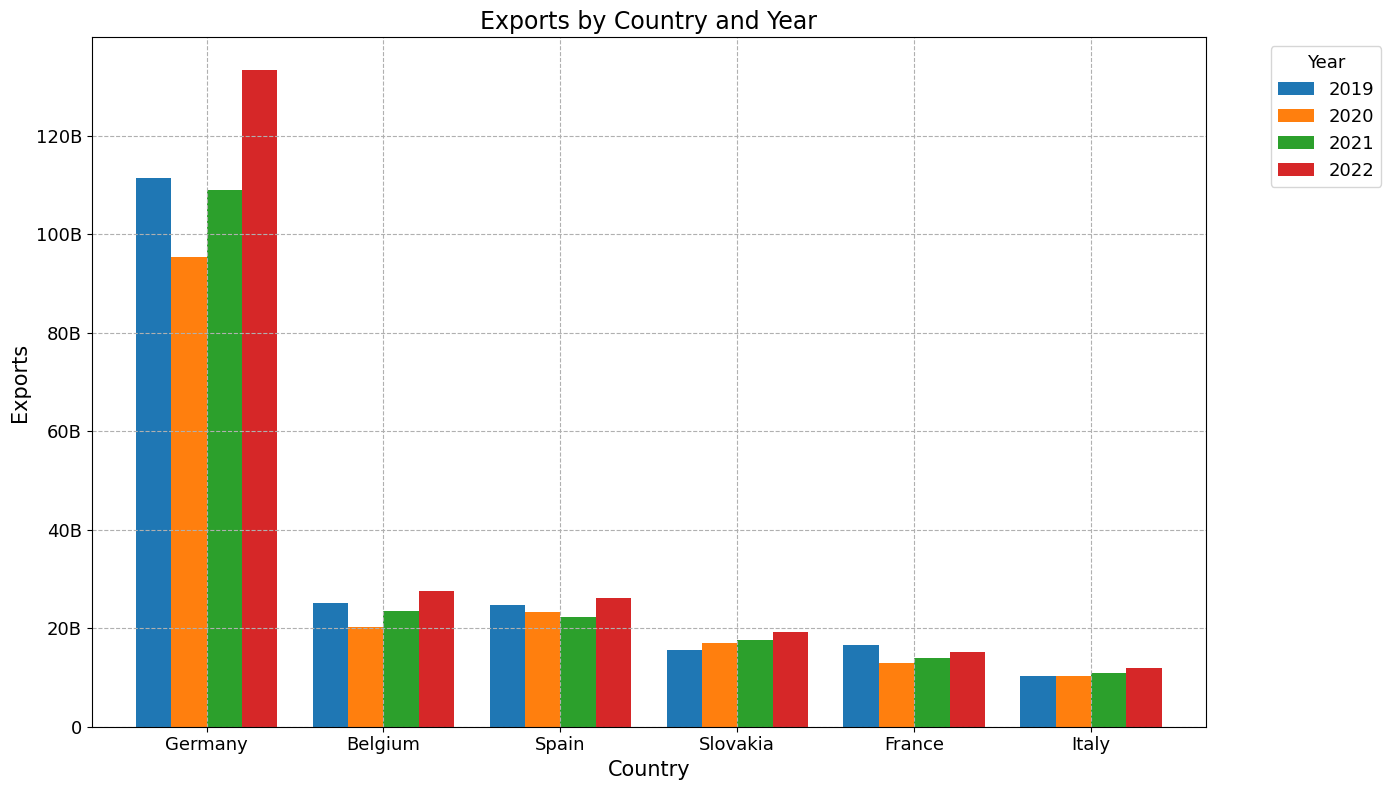

In [1063]:
df = pd.DataFrame(filtered_bar_data)

# Pivot the dataframe
pivot_df = df.pivot_table(index='Country', columns='Year', values='Exports')

# Fill NaN values with 0 if needed
pivot_df = pivot_df.fillna(0)

# Convert values to billions
pivot_df /= 1e9  # Divide by 1 billion

def billions_formatter(x, pos):
    return f'{x:.0f}B' if x > 0 else '0'

# Plotting
pivot_df.plot(kind='bar', figsize=(14, 8), width=0.8)  # Larger size for visibility
plt.xlabel('Country', fontsize=15)
plt.ylabel('Exports', fontsize=15)
plt.title('Exports by Country and Year', fontsize=17)
legend = plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=13)
legend.get_title().set_fontsize('13')
plt.xticks(rotation=0, fontsize=13)
plt.yticks(fontsize=13)

formatter = FuncFormatter(billions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Adding grid
plt.grid(axis='y', linestyle='--', zorder=2)  # Adding gridlines to y-axis
plt.grid(axis='x', linestyle='--', zorder=2)  # Adding gridlines to y-axis

plt.tight_layout()
plt.show()

**Insights on the export values of major players in the automobile industry**

Almost all of the biggest exporters, excluding Slovakia, took a hit during 2020, following the start of the Covid-19 pandemic. Italy did not suffer a significant decline in 2020, their export values decreased only by 1.4 percent. 
The affected countries were quick to recover in the years following 2020. Interestingly, all countries now report higher export values than before the pandemic. This could also be due to an increase in the inflation rate, the Ukraine war and other geopolitical reasons that followed or are unrelated to Covid-19.

The influential car exporters Slovakia and Italy were not as affected by the crisis. This could be due to some of the following reasons:

1) *Pricing / Inflation*: 
The increase in trade value could be correlated with a higher pricing of goods and not necessarily to the number of automobiles sold during Covid-19.

2) *Supply Chain Adaptability*: 
The ability of the automotive industry to quickly adapt its supply chain and manufacturing processes to the challenges posed by the pandemic might have contributed to maintaining production levels and meeting global demand. 
For example, Slovakia is the world's largest producer of cars per capita, with four car producers and hundreds of suppliers.

3) *Government Incentives and Support:*
Governments in various countries implemented stimulus packages and incentives to support industries affected by the pandemic. If countries provided support specifically to the automotive sector, it could have helped maintain production and exports.

4) *Innovation in Technology:*
If the automotive industry in the country is known for technological innovation, energy efficiency, or other factors that became more crucial during the pandemic, it might have gained a competitive edge in the global market. 
For example, Slovakia started a long-term strategy to transition to green cars in Covid-19. However, these cars are not allowed to be sold within the country for now. Exports may have been ongoing. Therefore, Slovakia might not have been as affected as others.

5) *Market Diversification:*
If the countried diversified their export destinations for automobiles, tapping into markets with stronger demand during the crisis, it could have offset declines in other regions.

## 6. Centrality measures

**Clustering coefficient**

In [1064]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G_dir)

# Average clustering coefficient
avg_clust = sum(clust_coefficients.values()) / len(clust_coefficients)
print("Average Clustering Coefficient:", avg_clust)
# = print("Average Clustering Coefficient (Built-in):", nx.average_clustering(cluster))

Average Clustering Coefficient: 0.6094059074073054


Even when only considering trade values over 200 million, the network still has a decently high clustering coefficient, showing the tightly-knit trade relationships between European countries.

**Node centralities**

In [1065]:
cluster = G_dir.to_undirected()

# Connected components are sorted in descending order of their size
G_components = sorted(nx.connected_components(cluster), key=len, reverse=True)
largest_component_nodes = G_components[0]

# Create a graph from the largest connected component
G_largest = G_dir.subgraph(largest_component_nodes).copy()

# Betweenness centrality
bet_cen = nx.betweenness_centrality(G_largest)
bet_cen_list = dict(sorted(bet_cen.items(), key=lambda x: x[1], reverse=True))

# Closeness centrality
clo_cen = nx.closeness_centrality(G_largest)
clo_cen_list = dict(sorted(clo_cen.items(), key=lambda x: x[1], reverse=True))

# Eigenvector centrality
eig_cen = nx.eigenvector_centrality(G_largest)
eig_cen_list = dict(sorted(eig_cen.items()), key=lambda x: x[1], reverse=True)

for node, centrality in list(bet_cen_list.items())[:5]:
    print(f"Node: {node}, Betweenness Centrality: {centrality}")
print()
for node, centrality in list(clo_cen_list.items())[:5]:
    print(f"Node: {node}, Closeness Centrality: {centrality}")
print()
for node, centrality in list(eig_cen_list.items())[:5]:
    print(f"Node: {node}, Eigenvector Centrality: {centrality}")

Node: DE, Betweenness Centrality: 0.1638701848260672
Node: FR, Betweenness Centrality: 0.028358950417773948
Node: BE, Betweenness Centrality: 0.023688770379946857
Node: ES, Betweenness Centrality: 0.018032063252651494
Node: CZ, Betweenness Centrality: 0.00805292202351026

Node: DE, Closeness Centrality: 0.3087606837606838
Node: IT, Closeness Centrality: 0.2778846153846154
Node: FR, Closeness Centrality: 0.2778846153846154
Node: BE, Closeness Centrality: 0.2526223776223776
Node: ES, Closeness Centrality: 0.2526223776223776

Node: AE, Eigenvector Centrality: 0.031630794543187894
Node: AT, Eigenvector Centrality: 0.20122956724842436
Node: AU, Eigenvector Centrality: 0.09123401934813109
Node: BE, Eigenvector Centrality: 0.25768577716042473
Node: BG, Eigenvector Centrality: 0.031630794543187894


## 7. Conclusion

As a summary, we have gathered a series of insights which we hope collectively provide a comprehensive understanding of the trade network, highlighting key features, challenges, and patterns in the context of car imports and exports.

**1) Degree Distribution**

- **Right-Skewed Distribution:**
  - Both in-degree and out-degree distributions are right-skewed.
  - Implies a small number of countries with significantly higher degrees, acting as "hubs" or dominant players in the network.<br>
<br>
- **Interpretations:**
  - **Hubs or Dominant Players:** Few countries have high in-degrees (importers) or out-degrees (exporters), indicating strong economic ties or significant market share.
  - **Trade Imbalances:** Skewed distribution suggests significant imbalances in car trade, with major importers and exporters.
  - **Specialization:** Countries with high out-degrees may specialize in car manufacturing, while high in-degrees may focus on importing.
  - **Network Structure:** Implies a hierarchical or scale-free structure, with a small number of central nodes.

**2) Major Exporters' Changes in Trade Values**

- **Impact of Covid-19:**
  - Most major exporters, except Slovakia, experienced a decline in 2020 due to the pandemic.
  - Quick recovery observed in subsequent years, with export values surpassing pre-pandemic levels.
<br>
- **Possible Reasons for Resilience:**
  - **Pricing/Inflation:** Increased trade value may be tied to higher pricing rather than increased sales.
  - **Supply Chain Adaptability:** Automotive industry's quick adaptation to supply chain challenges.
  - **Government Support:** Stimulus packages and incentives to support the automotive sector.
  - **Innovation:** Competitive edge through technological innovation and energy efficiency.
  - **Market Diversification:** Tapping into diverse markets with stronger demand during the crisis.

**3) Relationship Between Partners and Trade Value**

- **Number of Partners and Trade Value:**
  - Number of partners appears closely related to trade value of exports and imports.
  - Changes in node number not necessarily correlated with trade value.
  - Degree may not be a consistent predictor of trade value.

**4) Scale-Free Model**

- **Scale-Free Network:**
  - The right-skewed degree distribution suggests a scale-free network.
  - Scale-free networks have a small number of highly connected nodes and many nodes with lower connectivity.

